# Lab9 动态主题模型（Dynamic Topic Models）


## 参考
- LDA科普：[LDA数学八卦](http://www.flickering.cn/%E6%95%B0%E5%AD%A6%E4%B9%8B%E7%BE%8E/2014/06/%E3%80%90lda%E6%95%B0%E5%AD%A6%E5%85%AB%E5%8D%A6%E3%80%91%E7%A5%9E%E5%A5%87%E7%9A%84gamma%E5%87%BD%E6%95%B0/)
- gensim官方的案例：[Dynamic Topic Models Tutorial](http://nbviewer.jupyter.org/github/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb)
- gensim官方文本预处理：[Tutorial 1: Corpora and Vector Spaces](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Corpora_and_Vector_Spaces.ipynb)
- gensim-python的函数解释：[Dynamic Topic Modeling in Python](https://radimrehurek.com/gensim/models/ldaseqmodel.html)
- 相关论文：[Dynamic Topic Models](http://repository.cmu.edu/cgi/viewcontent.cgi?article=2036&context=compsci)
- 英文博客：[Understanding and Coding Dynamic Topic Models](https://rare-technologies.com/understanding-and-coding-dynamic-topic-models/)
- 中文博客：[pyLDA系列︱考量时间因素的动态主题模型（Dynamic Topic Models](https://blog.csdn.net/sinat_26917383/article/details/79377761)

## 并行爬虫

- 三线程爬虫

In [ ]:
p=Pool(3)
p.map(function,parameters)
p.close()
p.join()

- 输入爬取的关键字及页码即可自动爬取
![并行爬取](并行爬虫.png)

- 爬好的原始文件

![爬取的文件](爬取的新闻csv文件.png)

## 对爬取的原始文件初步预处理
- 批量读取爬虫原文件，合并数据框：df.append
- 删除重复的新闻文本： pd.drop_duplicates()
- 如果新闻详情为空，则把摘要补过去
- 删除新闻详情仍为空的文本
- 划分时间段（见下方）
- 生成预处理好的新闻文档：[alldata.csv](alldata.csv)

- 导进去的文档是按照时间顺序从早到晚排列，也就是说，df中最开始的是4月17日的文档，最末尾的是5月19日的文档。下面的clean_text也是按顺序的，这一点对之后建立动态主题模型很重要。

In [1]:
import os
import pandas as pd
os.chdir("E:/graduate/class/Statistical Case Studies/homework9")
df = pd.read_csv("alldata.csv",encoding = "gb18030")
df.head(3)

,abstract,date,detail,href,origin_url,source,time,title,interval,interval_int,period
0,事件：2018年04月16日，美国商务部发布对中兴通讯出口权限禁令，禁止美国企业向其出售零部...,2018-04-17,本文来源于\n，作者为电子行业分析师团队，联系人鄢凡、方竞。\n事件：2018年04月16日...,http://finance.sina.com.cn/stock/hkstock/ggscy...,https://www.zhitongcaijing.com/content/detail/...,港股综合,09:14:41,招商证券点评中兴通讯事件：贸易战之矛刺向缺芯软肋,1 days 00:00:00.000000000,1,1
1,4月16日晚间，美国商务部发布对中兴通讯的出口禁令，直到2025年3月13日，美国公司将被禁...,2018-04-17,\n来源：每日经济新闻\n站在中美贸易摩擦的风口浪尖，中兴成了美国打击中国信息技术产业的“活...,http://finance.sina.com.cn/chanjing/gsnews/201...,NaN,新浪综合,13:27:31,美国给中兴开7年禁购令 媒体：制裁看起来更像场阳谋,1 days 00:00:00.000000000,1,1
2,因此，中兴被禁购买美国零部件，如果集团因此无法正常生产，预计对当前的全球和中国的运营商网络建...,2018-04-17,中金报告中称，由于美国认为中兴（00763）曾向美国做虚假陈述，未按约定处罚参与非法向伊朗和...,http://finance.sina.com.cn/stock/hkstock/hkgg/...,https://www.zhitongcaijing.com/content/detail/...,新浪港股,15:32:40,中金：维持中兴推荐评级 目标价40元,1 days 00:00:00.000000000,1,1


## 事件经过
- **2018年4月16日晚**，美国商务部发布公告称，美国政府在未来7年内禁止中兴通讯向美国企业购买敏感产品。
- **2018年4月19日**，针对中兴被美国“封杀”的问题，商务部表示，中方密切关注进展，随时准备采取必要措施，维护中国企业合法权益。
- **2018年4月20日**，中兴通讯发布关于美国商务部激活拒绝令的声明，称在相关调查尚未结束之前，美国商务部工业与安全局执意对公司施以最严厉的制裁，对中兴通讯极不公平，“不能接受！”
- **2018年4月22日晚间**，中兴通讯公告，2016年4月以来，公司吸取过去在出口管制合规方面的教训，高度重视出口管制合规工作，把合规视为公司战略的基石和经营的前提及底线。美国商务部工业与安全局激活拒绝令，公司已经且正在采取措施以遵守该拒绝令。公司积极与相关方沟通以及寻求解决方案。
- **2018年5月1日**，中兴通讯发布公告称，公司收到BIS的指引，内容有关美国商务部接受并审议本公司提交的补充资料的程序。公司预计将按照上述程序向BIS提供资料。同时，公司将在必要的情况下考虑采取相关美国法律下可采取的行政或法律措施。公司股票将继续停牌
- **2018年5月4日**，商务部新闻发言人应询答记者问时表示，在3日至4日举行的中美经贸磋商中，中方就中兴公司案与美方进行了严正交涉。美方表示，重视中方交涉，将向美总统报告中方立场
- **2018年5月4日晚间**，中兴通讯发布名为《坚定信心力争更短时间解决问题》的内部员工信。中兴表示，目前已正式向BIS提交了关于暂停执行拒绝令的申请，并根据BIS指引提交了补充材料。
- **2018年5月9日**，中兴通讯公告称，受拒绝令影响，本公司主要经营活动已无法进行。
- **2018年5月13日11点**，特朗普发布推文：“我和习主席正携手合作，为中国的通信巨头中兴通讯提供一条快速重返经营正轨的道路。（中兴受制裁）使得太多的工作岗位在中国流失了。我已经指示美国商务部尽快完成手续。”
- **2018年5月15日**，美国商务部长威尔伯罗斯表示，愿意尽快改变对中国手机制造商中兴通讯的销售禁令，此前一天美国总统特朗普表示，要求美国商务部帮助中兴通讯恢复运营。

## 时间段划分

- 不同日期的新闻数

In [2]:
df["date"]= pd.to_datetime(df["date"],format="%Y-%m-%d")
df["date"].value_counts(sort = True)

2018-04-17    75
2018-04-18    72
2018-04-19    62
2018-05-15    18
2018-05-17    15
2018-04-20    14
2018-05-14    14
2018-05-16    12
2018-04-23    11
2018-04-24    10
2018-04-22    10
2018-04-21     9
2018-04-28     8
2018-05-18     7
2018-04-27     5
2018-04-29     4
2018-04-25     3
2018-05-02     1
2018-05-03     1
2018-05-10     1
Name: date, dtype: int64

- 距离4月16日的天数
- 可以看到4月16日事情发生后的3天内新闻较多，之后很少，因为5月13日特朗普发推文，中兴事件有了转机，因此新闻又多起来了。

In [3]:
df["interval_int"].value_counts(sort = False)

1     75
2     72
3     62
4     14
5      9
6     10
7     11
8     10
9      3
11     5
12     8
13     4
16     1
17     1
24     1
28    14
29    18
30    12
31    15
32     7
Name: interval_int, dtype: int64

- 考虑到“中兴事件”的事态进展，以及爬取的新闻数量可能影响后续主题模型的建立，因此时间段的划分尽可能按等数目划分和按事态发展的时间点划分

时间 | 事件 | 新闻数|时间段
- | :-: | -: 
4月17日 | 美国商务部：制裁中兴通讯| 75|1
4月18日 ||72|2
4月19日 |中方表态：密切关注进展，随时准备采取必要措施，维护中国企业合法权益。|62|3
4月20日—5月10日|中兴通讯发布公告：对美国商务部激活拒绝令的声明“不能接受！”等多次公告|76|4
5月14日—|特朗普发推文：将恢复中兴通讯在美经营|67|5

## 文本预处理
- 去除停用词
- 去除中英文标点符号、特殊字符
- 去除只出现过一次的词
- jieba分词

In [4]:
from collections import Counter,defaultdict
import os
import pandas as pd
import re
import jieba
import numpy as np
import operator

def get_text(data):
    text=data["detail"]
    text = text.dropna() 
    len(text)
    text=[t.encode('utf-8').decode("utf-8") for t in text] 
    return text
def get_stop_words(file='stopWord.txt'):
    file = open(file, 'rb').read().decode('utf8').split(',')
    file = [line.strip() for line in file]
    return set(file)                                         #查分停用词函数


def rm_tokens(words):                                        # 去掉一些停用词和完全包含数字的字符串
    words_list = list(words)
    stop_words = get_stop_words()
    for i in range(words_list.__len__())[::-1]:
        if words_list[i] in stop_words:                      # 去除停用词
            words_list.pop(i)
        elif words_list[i].isdigit():
            words_list.pop(i)
    return words_list



def rm_char(text):

    text = re.sub('\x01', '', text)                        #全角的空白符
    text = re.sub('\u3000', '', text) 
    text = re.sub(r"[\)(↓%·▲ \s+】【]","", text.encode("utf-8").decode("utf-8")) 
    text = re.sub(r"[\n\da-z+（）《》↗><‘’“”.-]","",text,flags=re.I)
    text = re.sub('\n+', " ", text)
    text = re.sub('[，、：。！？?；——]', " ", text)
#    text = re.sub(' +', "E S", text)
    return text

def convert_doc_to_wordlist(str_doc, cut_all=False):
    sent_list = str_doc.split('\n')
    sent_list = map(rm_char, sent_list)                       # 去掉一些字符，例如\u3000
    word_2dlist = [rm_tokens(jieba.cut(part, cut_all=cut_all))
                   for part in sent_list]                     # 分词
    word_list = sum(word_2dlist, [])
    rm_space = [w for w in word_list if w not in [""," "]]
    return rm_space

def rm_1ow_freq_word(texts,low_freq=1):
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    
    texts = [[token for token in text if frequency[token] > low_freq] for text in texts]
    return texts

#增加未登录词
jieba.add_word("中美")
jieba.add_word("中美贸易战")
jieba.add_word("习主席")
jieba.add_word("中国商务部")
jieba.add_word("拒绝令")
jieba.add_word("不公平")
jieba.add_word("推文")
jieba.add_word("推特")

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\situ\AppData\Local\Temp\jieba.cache
Loading model cost 1.234 seconds.
Prefix dict has been built succesfully.


In [5]:
clean_text=[convert_doc_to_wordlist(line) for line in get_text(df)] #去除停用词、标点、数字、特殊字符、分词
clean_text2 = rm_1ow_freq_word(clean_text)#去除只出现过一次的词

- An Example

In [6]:
"/".join(clean_text2[302])

'北京/商报讯/记者/蒋梦惟/中美/新一轮/贸易/磋商/正式/开启/外交部/例行/记者会/上/外交部/新闻/发言人/陆慷/宣布/应/美国政府/邀请/习近平/主席/特使/中共中央政治局/委员/国务院/副/总理/中美/全面/经济/对话/中方/牵头/人/刘鹤/日日/赴美/访问/届时/刘鹤/美国/财政部长/姆/努钦/率领/美方/经济/团队/继续/两国/经贸/问题/进行/磋商/值得注意/发布会/上/陆慷/还/赞赏/美国/总统/特朗普/推特/表示/正/努力/中兴/提供/恢复/业务/办法/目前/正在/美方/落实/具体/细节/保持/密切/沟通/本轮/中美/贸易/摩擦/过程/中/顺利/中兴/事件/达成/共识/无疑/两方/必须/面对/重点/问题/美国/当地/时间/中兴通讯/美国商务部/下达/禁售/令/一个月/后/特朗普/社交/媒体/推特/表示/习近平/主席/正/共同努力/大型/中国/通信/公司/中兴/提供/迅速/恢复/业务/办法/已/指示/美/商务部/处理/此事/业界/视/做/本次/刘鹤/访美/前/美方/释放/一个/重要/积极/信号/对此/陆慷/表示/十分/赞赏/美方/中兴公司/问题/做/积极/表态/正在/美方/落实/具体/细节/保持/密切/沟通/美方/关注/一些/具体/问题/中美/双方/保持/密切/沟通/其实/截至/目前/刘鹤/已经/多次/中美/全面/经济/对话/中方/牵头/人/身份/参与/中美/磋商/今年/月底/牵头/人/身份/刘鹤/曾/访问/美国/刘鹤/再次/以该/角色/应约/姆/努钦/通话/当时/姆/努钦/中方/通报/美方/公布/调查报告/最新/情况/刘鹤则/表示/美方/公布/调查报告/违背/国际贸易/规则/不利于/中方/利益/不利于/美方/利益/不利于/全球/利益/中方/已经/做好/准备/实力/捍卫/国家/利益/希望/双方/保持/理性/共同努力/维护/中美/经贸关系/总体/稳定/大局/双方同意/继续/就此/保持/沟通/实际上/月初/美方/赴华/进行/讨论/后/新华社/曾/发布/消息/称/双方/均/认为/发展/健康/稳定/中美/经贸关系/两国/十分/重要/致力于/对话/磋商/解决/经贸/问题/双方/扩大/美/对华/出口/双边/服务/贸易/双向/投资/保护/知识产权/解决/关税/措施/问题/充分/交换/意见/领域/达成/一些/共识/双方/认识/一些/问题/上/还/存在/较大/分歧

## 动态主题模型
- gensim：一个python的专门做主题模型的库，它的官方介绍是：Topic modelling for humans

### 利用分好词的文本建立gensim格式的字典
- 字典格式：**{词：索引号}** 即一个词有对应一个索引
- 可以看到字典中一共有12633个词

In [7]:
from gensim import corpora
import os
import tempfile
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
dictionary = corpora.Dictionary(clean_text2)
dictionary.save(os.path.join(TEMP_FOLDER, 'deerwester.dict'))  # store the dictionary, for future reference
print(dictionary)
print(dictionary.token2id)

C:\Users\situ\Anaconda2\envs\py3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Folder "C:\Users\situ\AppData\Local\Temp" will be used to save temporary dictionary and corpus.
Dictionary(12633 unique tokens: ['营运', '复制', '亿总', '尼尔森', '回旋']...)
{'营运': 3773, '复制': 2660, '亿总': 11005, '尼尔森': 11708, '回旋': 9013, '不容忽视': 966, '幼稚': 8138, '曾': 752, '法务部': 2433, '看成': 6504, '蛇': 5698, '预售': 12078, '美国司法部': 832, '特长': 2919, '外贸公司': 9658, '古典': 11150, '传送': 6931, '营商': 7403, '系列性': 8601, '工业品': 11980, '创通': 1445, '灾难性': 9288, '一路': 1275, '评审': 3042, '价款': 8655, '敲定': 8676, '牢牢': 6082, '超微': 1998, '百战': 2208, '苏莱曼': 6982, '整套': 2330, '仪表': 9261, '总监': 702, '事半功倍': 12147, '多亿元': 12348, '同一个': 9232, '举': 3226, '坚船利炮': 7848, '标明': 343, '任期': 3951, '知名品牌': 12389, '竞争对手': 403, '进口国': 10177, '搬回': 5964, '伸张正义': 7352, '示波器': 2964, '加油': 8795, '劣势': 5856, '力图': 11145, '高歌猛进': 8381, '昨天晚上': 9870, '电力设备': 5570, '卖盘': 4574, '外交': 3998, '演化': 6501, '担忧': 3526, '其自产': 8201, '一声': 7341, '代替': 4263, '盈利': 1864, '条': 5562, '养着': 7817, '感觉良好': 7884, '庆幸': 6051, '华盛': 11542, '梁孟松': 10865, '传输速

### 利用分好词的文本建立gensim格式的语料库
- 可以看到一共有352条文本
- 语料库格式：**(词索引，词出现的次数)**

In [8]:
corpus = [dictionary.doc2bow(text) for text in clean_text2]

corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'deerwester.mm'), corpus)  # store to disk, for later use
len(corpus)

352

In [9]:
corpus[0] #第1条新闻文本

[(0, 2),
 (1, 4),
 (2, 2),
 (3, 4),
 (4, 2),
 (5, 4),
 (6, 2),
 (7, 2),
 (8, 4),
 (9, 4),
 (10, 4),
 (11, 2),
 (12, 2),
 (13, 2),
 (14, 2),
 (15, 2),
 (16, 2),
 (17, 2),
 (18, 2),
 (19, 2),
 (20, 2),
 (21, 2),
 (22, 2),
 (23, 2),
 (24, 2),
 (25, 2),
 (26, 18),
 (27, 10),
 (28, 18),
 (29, 4),
 (30, 2),
 (31, 2),
 (32, 2),
 (33, 4),
 (34, 2),
 (35, 2),
 (36, 10),
 (37, 2),
 (38, 22),
 (39, 2),
 (40, 2),
 (41, 2),
 (42, 2),
 (43, 4),
 (44, 2),
 (45, 12),
 (46, 2),
 (47, 2),
 (48, 2),
 (49, 4),
 (50, 8),
 (51, 4),
 (52, 14),
 (53, 2),
 (54, 2),
 (55, 4),
 (56, 2),
 (57, 2),
 (58, 2),
 (59, 2),
 (60, 2),
 (61, 4),
 (62, 2),
 (63, 2),
 (64, 2),
 (65, 2),
 (66, 2),
 (67, 6),
 (68, 2),
 (69, 2),
 (70, 2),
 (71, 2),
 (72, 2),
 (73, 2),
 (74, 2),
 (75, 4),
 (76, 2),
 (77, 2),
 (78, 2),
 (79, 2),
 (80, 2),
 (81, 2),
 (82, 2),
 (83, 2),
 (84, 18),
 (85, 2),
 (86, 6),
 (87, 10),
 (88, 2),
 (89, 8),
 (90, 16),
 (91, 2),
 (92, 2),
 (93, 2),
 (94, 2),
 (95, 6),
 (96, 2),
 (97, 2),
 (98, 4),
 (99, 2),


### 建立动态主题模型
- time_slice是一个列表，指定每个时间段的文本数。如下所示，第一个时间段有75篇新闻，第二个时间段有72篇新闻......第五个时间段有67篇新闻。因此语料库按照时间顺序排好很重要

In [10]:
from gensim.models import ldaseqmodel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

time_slice = list(df["period"].value_counts(sort=False))
time_slice

[75, 72, 62, 76, 67]

- ldaseqmodel.LdaSeqModel，建立动态主题模型，即加入时间因素，可使不同主题随着时间变动
- 因为主题为中兴事件，只有一个，设置num_topics=1
- 考虑到运行时间，设置lda迭代次数为15，EM算法迭代次数为10
- 为使不同时间段的主题差异度大一些，设置chain_variance=50

In [18]:
#运行好慢。。。。。大概10分钟
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, 
                                 time_slice=time_slice, num_topics=5,
                                 lda_inference_max_iter=15,
                                 em_max_iter=10,
                                 chain_variance=1)


2018-06-03 15:40:41,180 : INFO : using symmetric eta at 0.2
2018-06-03 15:40:41,186 : INFO : using serial LDA version on this node
2018-06-03 15:40:41,192 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 352 documents, updating model once every 352 documents, evaluating perplexity every 352 documents, iterating 50x with a convergence threshold of 0.001000
2018-06-03 15:40:41,936 : INFO : -10.066 per-word bound, 1072.2 perplexity estimate based on a held-out corpus of 352 documents with 317450 words
2018-06-03 15:40:41,936 : INFO : PROGRESS: pass 0, at document #352/352
2018-06-03 15:40:42,269 : INFO : topic #0 (0.010): 0.013*"芯片" + 0.013*"中兴" + 0.013*"中兴通讯" + 0.012*"美国" + 0.011*"中国" + 0.008*"公司" + 0.007*"美国商务部" + 0.006*"企业" + 0.006*"上" + 0.005*"中"
2018-06-03 15:40:42,269 : INFO : topic #1 (0.010): 0.021*"美国" + 0.016*"中国" + 0.016*"中兴" + 0.010*"芯片" + 0.009*"中兴通讯" + 0.009*"公司" + 0.005*"影响" + 0.005*"企业" + 0.005*"技术" + 0.004*"表示"
2018-06-03 

2018-06-03 15:40:47,926 : INFO : topic #3 (0.010): 0.021*"中兴" + 0.020*"美国" + 0.017*"中兴通讯" + 0.011*"芯片" + 0.011*"公司" + 0.009*"中国" + 0.009*"美国商务部" + 0.008*"企业" + 0.006*"中" + 0.006*"影响"
2018-06-03 15:40:47,927 : INFO : topic #4 (0.010): 0.018*"芯片" + 0.014*"公司" + 0.012*"中国" + 0.009*"中兴" + 0.008*"美国" + 0.006*"中兴通讯" + 0.006*"产业" + 0.006*"企业" + 0.005*"影响" + 0.005*"事件"
2018-06-03 15:40:47,928 : INFO : topic diff=0.177221, rho=0.353553
2018-06-03 15:40:48,609 : INFO : -7.630 per-word bound, 198.1 perplexity estimate based on a held-out corpus of 352 documents with 317450 words
2018-06-03 15:40:48,609 : INFO : PROGRESS: pass 7, at document #352/352
2018-06-03 15:40:48,866 : INFO : topic #0 (0.010): 0.014*"芯片" + 0.014*"中国" + 0.008*"发展" + 0.008*"技术" + 0.007*"核心技术" + 0.007*"产业" + 0.007*"中兴" + 0.007*"美国" + 0.007*"上" + 0.006*"企业"
2018-06-03 15:40:48,866 : INFO : topic #1 (0.010): 0.025*"美国" + 0.023*"中国" + 0.014*"中兴" + 0.007*"芯片" + 0.006*"公司" + 0.006*"企业" + 0.005*"贸易" + 0.005*"中美" + 0.005*"特朗普" + 0.00

2018-06-03 15:44:14,846 : INFO : Computing bound, all times
2018-06-03 15:44:15,214 : INFO : iteration 1 iteration lda seq bound is -469133.042041 convergence is 0.005700
2018-06-03 15:44:21,882 : INFO : Computing bound, all times
2018-06-03 15:44:22,263 : INFO : iteration 2 iteration lda seq bound is -468020.713622 convergence is 0.002371
2018-06-03 15:44:22,395 : INFO : Fitting topic number 2
2018-06-03 15:44:23,007 : INFO : Computing bound, all times
2018-06-03 15:44:23,374 : INFO : initial sslm bound is -363471.638169
2018-06-03 15:44:29,662 : INFO : Computing bound, all times
2018-06-03 15:44:30,026 : INFO : iteration 1 iteration lda seq bound is -361198.695152 convergence is 0.006253
2018-06-03 15:44:36,339 : INFO : Computing bound, all times
2018-06-03 15:44:36,712 : INFO : iteration 2 iteration lda seq bound is -360119.196231 convergence is 0.002989
2018-06-03 15:44:36,842 : INFO : Fitting topic number 3
2018-06-03 15:44:37,405 : INFO : Computing bound, all times
2018-06-03 15:

2018-06-03 15:49:14,264 : INFO : using serial LDA version on this node
2018-06-03 15:50:05,789 : INFO : M Step
2018-06-03 15:50:05,790 : INFO : Fitting topic number 0
2018-06-03 15:50:06,443 : INFO : Computing bound, all times
2018-06-03 15:50:06,903 : INFO : initial sslm bound is -293387.674158
2018-06-03 15:50:13,164 : INFO : Computing bound, all times
2018-06-03 15:50:13,594 : INFO : iteration 1 iteration lda seq bound is -293050.822104 convergence is 0.001148
2018-06-03 15:50:19,304 : INFO : Computing bound, all times
2018-06-03 15:50:19,719 : INFO : iteration 2 iteration lda seq bound is -292860.161999 convergence is 0.000651
2018-06-03 15:50:19,863 : INFO : Fitting topic number 1
2018-06-03 15:50:20,491 : INFO : Computing bound, all times
2018-06-03 15:50:20,871 : INFO : initial sslm bound is -496657.952350
2018-06-03 15:50:28,322 : INFO : Computing bound, all times
2018-06-03 15:50:28,771 : INFO : iteration 1 iteration lda seq bound is -496317.039571 convergence is 0.000686
2018

2018-06-03 15:55:12,036 : INFO : Fitting topic number 4
2018-06-03 15:55:12,625 : INFO : Computing bound, all times
2018-06-03 15:55:12,986 : INFO : initial sslm bound is -411774.479073
2018-06-03 15:55:18,160 : INFO : Computing bound, all times
2018-06-03 15:55:18,547 : INFO : iteration 1 iteration lda seq bound is -411603.751034 convergence is 0.000415
2018-06-03 15:55:23,914 : INFO : Computing bound, all times
2018-06-03 15:55:24,282 : INFO : iteration 2 iteration lda seq bound is -411488.901500 convergence is 0.000279
2018-06-03 15:55:24,416 : INFO : iteration 6 iteration lda seq bound is -4656462.310977 convergence is 0.001258
2018-06-03 15:55:24,416 : INFO :  EM iter 7
2018-06-03 15:55:24,416 : INFO : E Step
2018-06-03 15:55:24,416 : INFO : using symmetric eta at 0.2
2018-06-03 15:55:24,416 : INFO : using serial LDA version on this node
2018-06-03 15:56:10,756 : INFO : M Step
2018-06-03 15:56:10,756 : INFO : Fitting topic number 0
2018-06-03 15:56:11,342 : INFO : Computing bound,

2018-06-03 16:00:31,809 : INFO : iteration 1 iteration lda seq bound is -380973.612941 convergence is 0.000170
2018-06-03 16:00:36,919 : INFO : Computing bound, all times
2018-06-03 16:00:37,304 : INFO : iteration 2 iteration lda seq bound is -380934.069320 convergence is 0.000104
2018-06-03 16:00:37,459 : INFO : Fitting topic number 3
2018-06-03 16:00:38,030 : INFO : Computing bound, all times
2018-06-03 16:00:38,418 : INFO : initial sslm bound is -743455.508692
2018-06-03 16:00:46,845 : INFO : Computing bound, all times
2018-06-03 16:00:47,220 : INFO : iteration 1 iteration lda seq bound is -743261.923369 convergence is 0.000260
2018-06-03 16:00:55,267 : INFO : Computing bound, all times
2018-06-03 16:00:55,658 : INFO : iteration 2 iteration lda seq bound is -743104.013394 convergence is 0.000212
2018-06-03 16:00:55,783 : INFO : Fitting topic number 4
2018-06-03 16:00:56,376 : INFO : Computing bound, all times
2018-06-03 16:00:56,751 : INFO : initial sslm bound is -418385.689227
2018

In [19]:
ldaseq.save("ldaseq")#保存模型，以后就不用每次都运行一次了
#ldaseq =  ldaseqmodel.LdaSeqModel.load('ldaseq') 

2018-06-03 16:16:25,757 : INFO : saving LdaSeqModel object under ldaseq, separately None
2018-06-03 16:16:26,459 : INFO : saved ldaseq


- 输出一个时间段的主题词

In [13]:

#ldaseq.print_topics(time=0)
#ldaseq.print_topics(time=1)
#ldaseq.print_topics(time=2)
#ldaseq.print_topics(time=3)
ldaseq.print_topics(time=4)#最近一段时间的主题词

[[('中国', 0.014852947553643442),
  ('美国', 0.014575071459557097),
  ('特朗普', 0.0075095543474147071),
  ('中美', 0.0070127835065001152),
  ('智', 0.006509581023769688),
  ('上', 0.0063996111736426622),
  ('厦门', 0.0059664503531164318),
  ('嘉楠耘', 0.0054236684832652147),
  ('公司', 0.0053704881732515464),
  ('市场', 0.0053653027018414337),
  ('比特', 0.0051521707128304372),
  ('币', 0.0046093249099479448),
  ('经济', 0.0045364444625534519),
  ('贸易', 0.0044998585945562946),
  ('中方', 0.0042537828691060885),
  ('中', 0.0042320765298868449),
  ('人才', 0.0039840135994840056),
  ('亿元', 0.0039262298721712986),
  ('问题', 0.0038123983175546382),
  ('美方', 0.0036916476576311433)],
 [('美国', 0.014835946753054711),
  ('中兴通讯', 0.014328107784854875),
  ('中国', 0.01106401626443795),
  ('中兴', 0.010763419730718683),
  ('特朗普', 0.0092407489751782455),
  ('表示', 0.008940721442491549),
  ('公司', 0.0079044247581029192),
  ('称', 0.0073156319710741893),
  ('事件', 0.0072070791128569971),
  ('美方', 0.0069176077442224806),
  ('富士康', 0.006015

- 输出同一个主题在所有时间段的主题词

In [14]:
ldaseq.print_topic_times(topic=0, top_terms=15)

[[('中国', 0.014933694173670483),
  ('芯片', 0.012770116607806411),
  ('美国', 0.010761608290130785),
  ('市场', 0.010630660781324346),
  ('中兴', 0.0087543923035338835),
  ('产业', 0.0079256809119108932),
  ('华为', 0.0056984553215709719),
  ('不', 0.0056247557945142568),
  ('国产', 0.0053993091494369677),
  ('产品', 0.005336940695470806),
  ('事件', 0.0048495537688124186),
  ('一个', 0.0045793971620498386),
  ('上', 0.0045234889370293291),
  ('技术', 0.004106969809379816),
  ('股', 0.0040006066806793517)],
 [('中国', 0.018671108858962483),
  ('中兴', 0.013904594466556952),
  ('核心技术', 0.012877089518766904),
  ('技术', 0.0090233089589847135),
  ('发展', 0.0085959526836681191),
  ('芯片', 0.0084790517982091494),
  ('企业', 0.0078213943473606998),
  ('美国', 0.0073111241694857349),
  ('高科技', 0.0065146560884948943),
  ('一个', 0.0063487350488512836),
  ('创新', 0.0059205629835921468),
  ('大', 0.0056236189575915906),
  ('不能', 0.0051892416896328376),
  ('世界', 0.0046949803448281674),
  ('领域', 0.0046641410418801488)],
 [('中国', 0.0236377

### 找出在不同时间段波动较大的词
- 这些词最能体现不同时间段的特点

In [14]:
#保存所有时间段的前2000个主题词
topwords = ldaseq.print_topic_times(topic=0, top_terms=2000) 

#找5个时期，概率波动最大的词
word_pro = {}#保存词各个时间段的概率的字典
for tw in topwords:
    for w,p in tw:
#        print(w,p)
        if w not in word_pro:
            word_pro[w] = [p]
        else:
            word_pro[w].append(p)


word_var = {}#计算词的概率的标准差的字典
for w,p_list in word_pro.items():
    if len(p_list)==5:
        word_var[w]=np.std(p_list)
        
sorted_word_var = sorted(word_var.items(), key = operator.itemgetter(1), reverse=True) #=True 降序排列
sorted_word_var[:50]

[('芯片', 0.0047841374755462117),
 ('中兴通讯', 0.0044032844522042883),
 ('中兴', 0.0040233507576322453),
 ('美国', 0.0028427561221819968),
 ('美国商务部', 0.0025940374017653332),
 ('基金', 0.0021427629500707216),
 ('中国', 0.0021387505755296144),
 ('公司', 0.002024507700726908),
 ('特朗普', 0.001941590728143352),
 ('影响', 0.0018013205707186268),
 ('出口', 0.0017368737157862342),
 ('企业', 0.0016561777877753152),
 ('设备', 0.0016543725357137864),
 ('华为', 0.0012103512128694368),
 ('厂商', 0.0011838565965147491),
 ('制裁', 0.0011432051656408001),
 ('国产', 0.001137267103420603),
 ('通信', 0.0011247680088117158),
 ('禁运', 0.0010761777284584392),
 ('禁令', 0.0010380280916368122),
 ('制造', 0.0010287312064059893),
 ('上', 0.0010119364231880111),
 ('发展', 0.0010110023645910834),
 ('元器件', 0.00098266032722168291),
 ('中方', 0.00096703012359907554),
 ('产品', 0.00096653065500514773),
 ('协议', 0.00094880233034758826),
 ('高通', 0.00093409803596019149),
 ('全球', 0.00093089708860092854),
 ('问题', 0.00090762414335109629),
 ('员工', 0.00090044705674918247

In [48]:
#把波动比较大的前100个词在5个时间段的概率拎出来

var_word = [item[0] for item in sorted_word_var[:100] if len(item[0])>1]

word_pro_df = pd.DataFrame()
for w in var_word:
    onedf = pd.DataFrame({"word":[w],"p":[" ".join([str(p) for p in word_pro[w]])]})
    word_pro_df = word_pro_df.append(onedf)
word_pro_df
word_pro_df.to_csv("word_pro.csv",index=False)

![word_pro截图](word_pro截图.png)

### 每个时间段重要的主题词
- 画出它们的概率随时间变化的折线图，每个时期选几个主题词画一张，反映事态发展
- 词和每个时间段的概率在[word_pro.csv](word_pro.csv)
- 定义绘图函数

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl
sns.set(style='darkgrid', palette='muted', color_codes=True)
sns.set_context(rc={'figure.figsize': (8, 5) } )
zhfont1 = mpl.font_manager.FontProperties(fname='C:\Windows\Fonts\STSONG.TTF')


def plot_word_pro(word,color):
    for i in range(len(word)):
        plt.plot(list(range(5)), word_pro[word[i]],color[i],label = word[i])
    plt.legend(prop=zhfont1)
    plt.show()

#### 第一时期：4月17日

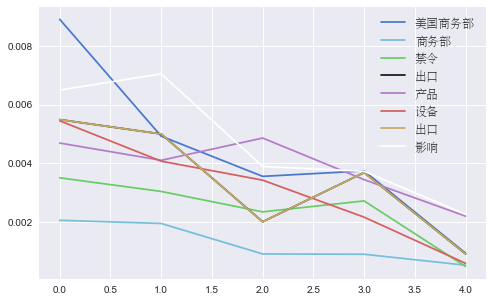

In [63]:
color = ["b","c","g","k","m","r","y","w"]
word1 = ["美国商务部","商务部","禁令","出口","产品","设备","影响"]
plot_word_pro(word1,color)
#1.美国商务部“制裁”中兴，断供芯片
#2.探讨中美贸易战对中国高科技产品、设备出口的影响

#### 第二时期：4月18日

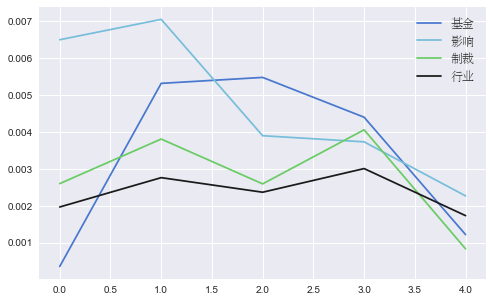

In [46]:
word2 = ['基金',"影响","制裁","行业"]
plot_word_pro(word2,color)
#1.制裁事件开始影响股市，基金公司更是不断调低中兴估值

#### 第三时期：4月19日

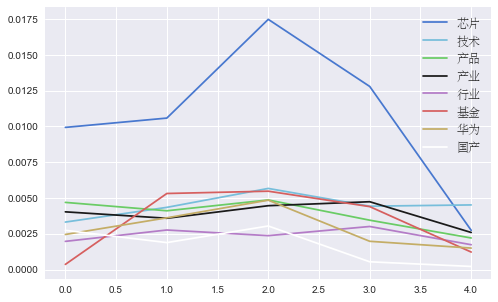

In [65]:
word3 = ['芯片',"技术","产品","产业","行业","基金","华为","国产"]
plot_word_pro(word3,color)
#探讨自主研发芯片的重要性，而华为正是自动研发芯片的代表企业

#### 第四时期：4月20日——5月12日

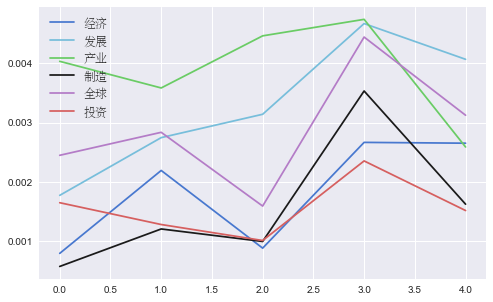

In [60]:
word4 = ['经济',"发展","产业","制造","全球","投资"]
plot_word_pro(word4,color)
#“中兴事件”激起中国对产业发展的反思和对攻克核心技术的决心。更加放眼世界，中国制造在新一轮全球竞争。

#### 第五时期：5月13日——5月19日

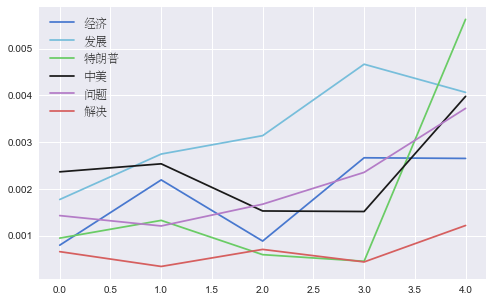

In [59]:
word5 = ['经济',"发展","特朗普","中美","问题","解决"]
plot_word_pro(word5,color)
#中美和谈，双方妥善处理好经贸问题，推动美中关系取得更大发展

In [ ]:
#第一时期
word_pro["美国商务部"]
word_pro["制裁"]
word_pro["禁令"]
word_pro["限制"]
word_pro["禁止"]
word_pro["商务部"]
word_pro["出口"]
word_pro["技术"]
word_pro["设备"]
word_pro['产品']
word_pro["拒绝令"]
word_pro['影响']  
word_pro["协议"]
word_pro['基站']  
word_pro["高通"]




#第二时期
word_pro['基金']
word_pro['影响']   
word_pro['芯片']  
word_pro['估值']  
word_pro["制裁"]
word_pro["行业"]

#第三时期
word_pro['基金']
word_pro['芯片']  
word_pro['技术']  
word_pro['产品']  
word_pro['产业']  
word_pro['华为']  
word_pro['厂商']  
word_pro['国产']
word_pro['核心技术'] 
word_pro["行业"]

#第四     
    
word_pro['经济']
word_pro['发展'] 
word_pro['产业']
word_pro['制造']
word_pro['全球']  
word_pro['出口']
word_pro['投资']

        
#第五时期    
word_pro["特朗普"]
word_pro['发展']
word_pro['经济']
word_pro['中美']
word_pro['问题']
word_pro['技术']
word_pro["恢复"]



## Visualising Dynamic Topic Models

In [20]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis

dtm_model = ldaseqmodel.LdaSeqModel.load('ldaseq') 

2018-06-03 16:16:42,432 : INFO : loading LdaSeqModel object from ldaseq
2018-06-03 16:16:42,544 : INFO : loading id2word recursively from ldaseq.id2word.* with mmap=None
2018-06-03 16:16:42,546 : INFO : loaded ldaseq


In [21]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = dtm_model.dtm_vis(time=0, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

C:\Users\situ\Anaconda2\envs\py3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]
C:\Users\situ\Anaconda2\envs\py3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]
